# IBM Watson Marketing AB Test - ANOVA model

In [10]:
#What's in my workspace? Uncomment and run if you want to check what files are in your workspace.
#!ls

# Import libraries and dataset

In [6]:
#import libraries
import pandas as pd
import numpy as np
import requests
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)

In [2]:
#Read data file into object called df
#I'm reading this file directly from the web
df = pd.read_csv("https://raw.githubusercontent.com/pthiagu2/DataMining/master/WA_Fn-UseC_-Marketing-Campaign-Eff-UseC_-FastF.csv")

print(df.head(5))

   MarketID MarketSize  LocationID  AgeOfStore  Promotion  week  \
0         1     Medium           1           4          3     1   
1         1     Medium           1           4          3     2   
2         1     Medium           1           4          3     3   
3         1     Medium           1           4          3     4   
4         1     Medium           2           5          2     1   

   SalesInThousands  
0             33.73  
1             35.67  
2             29.03  
3             39.25  
4             27.81  


# Data visualization and exploration

In [3]:
# Check column data types and non-missing values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
MarketID            548 non-null int64
MarketSize          548 non-null object
LocationID          548 non-null int64
AgeOfStore          548 non-null int64
Promotion           548 non-null int64
week                548 non-null int64
SalesInThousands    548 non-null float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.0+ KB
None


In [5]:
#Summary statistics
print(df.describe())

         MarketID  LocationID  AgeOfStore   Promotion        week  \
count  548.000000  548.000000  548.000000  548.000000  548.000000   
mean     5.715328  479.656934    8.503650    2.029197    2.500000   
std      2.877001  287.973679    6.638345    0.810729    1.119055   
min      1.000000    1.000000    1.000000    1.000000    1.000000   
25%      3.000000  216.000000    4.000000    1.000000    1.750000   
50%      6.000000  504.000000    7.000000    2.000000    2.500000   
75%      8.000000  708.000000   12.000000    3.000000    3.250000   
max     10.000000  920.000000   28.000000    3.000000    4.000000   

       SalesInThousands  
count        548.000000  
mean          53.466204  
std           16.755216  
min           17.340000  
25%           42.545000  
50%           50.200000  
75%           60.477500  
max           99.650000  


In [6]:
#Summary statistics of Age of store grouped by promotion
df.groupby('Promotion')['AgeOfStore'].describe()


,count,mean,std,min,25%,50%,75%,max
Promotion,,,,,,,,
1,172.0,8.279070,6.636160,1.0,3.0,6.0,12.0,27.0
2,188.0,7.978723,6.597648,1.0,3.0,7.0,10.0,28.0
3,188.0,9.234043,6.651646,1.0,5.0,8.0,12.0,24.0


In [27]:
#Summary statistics of weeks by promotion
df.groupby('Promotion')['week'].describe()

,count,mean,std,min,25%,50%,75%,max
Promotion,,,,,,,,
1,172.0,2.5,1.121298,1.0,1.75,2.5,3.25,4.0
2,188.0,2.5,1.121019,1.0,1.75,2.5,3.25,4.0
3,188.0,2.5,1.121019,1.0,1.75,2.5,3.25,4.0


In [5]:
#Summary statistics of sales by promotion
df.groupby('Promotion')['SalesInThousands'].describe()

,count,mean,std,min,25%,50%,75%,max
Promotion,,,,,,,,
1,172.0,58.099012,16.553782,30.81,46.3525,55.385,63.6175,99.65
2,188.0,47.329415,15.108955,17.34,38.1700,45.385,51.7450,88.64
3,188.0,55.364468,16.766231,22.18,44.1975,51.165,61.7325,96.48


In [29]:
#Total sales grouped by promotion
#We can see that group 3 created the most sales
df.groupby('Promotion', as_index=False).agg({"SalesInThousands": "sum"})

,Promotion,SalesInThousands
0,1,9993.03
1,2,8897.93
2,3,10408.52


In [33]:
#Total sales grouped by week and promotion
total_sales = df.groupby(['week', 'Promotion'])['SalesInThousands'].sum()
print(total_sales)

week  Promotion
1     1            2504.51
      2            2243.32
      3            2621.48
2     1            2447.97
      2            2236.38
      3            2629.61
3     1            2527.32
      2            2242.94
      3            2555.76
4     1            2513.23
      2            2175.29
      3            2601.67
Name: SalesInThousands, dtype: float64


In [34]:
#Mean sales grouped by week and promotion
avg_sales = df.groupby(['week', 'Promotion'])['SalesInThousands'].mean()
print(avg_sales)

week  Promotion
1     1            58.244419
      2            47.730213
      3            55.776170
2     1            56.929535
      2            47.582553
      3            55.949149
3     1            58.774884
      2            47.722128
      3            54.377872
4     1            58.447209
      2            46.282766
      3            55.354681
Name: SalesInThousands, dtype: float64


In [7]:
#Examine sales data grouped by promo and week
#group the data
grouped_promo_data = df.groupby(by=['Promotion', 'week'])

#aggregate the data
promo_summary = grouped_promo_data.agg({'SalesInThousands':['min', 'mean', 'median', 'max', 'std', 'sum']})

#examine the results
print(promo_summary)

               SalesInThousands                                             
                            min       mean median    max        std      sum
Promotion week                                                              
1         1               35.30  58.244419  53.79  99.65  16.798929  2504.51
          2               35.86  56.929535  55.11  96.01  16.553088  2447.97
          3               32.05  58.774884  56.19  99.12  16.423121  2527.32
          4               30.81  58.447209  56.84  97.61  16.962984  2513.23
2         1               27.81  47.730213  46.02  88.64  14.387406  2243.32
          2               17.34  47.582553  45.75  82.86  14.854098  2236.38
          3               23.93  47.722128  45.35  88.12  15.979831  2242.94
          4               19.26  46.282766  44.84  80.75  15.604704  2175.29
3         1               24.75  55.776170  51.01  96.48  18.071909  2621.48
          2               22.18  55.949149  53.47  90.30  15.643490  2629.61

In [4]:
#Examine the store characteristics grouped by promotion
#group the data
grouped_store_data = df.groupby(by=['Promotion'])

#aggregate the data
store_summary = grouped_store_data.agg({'AgeOfStore':['min', 'mean', 'median', 'max', 'std']})

#examine the results
print(store_summary)

          AgeOfStore                               
                 min      mean median max       std
Promotion                                          
1                  1  8.279070      6  27  6.636160
2                  1  7.978723      7  28  6.597648
3                  1  9.234043      8  24  6.651646


Stores appear to be similar across promotions with the exception of stores in promotion 1 just slightly younger

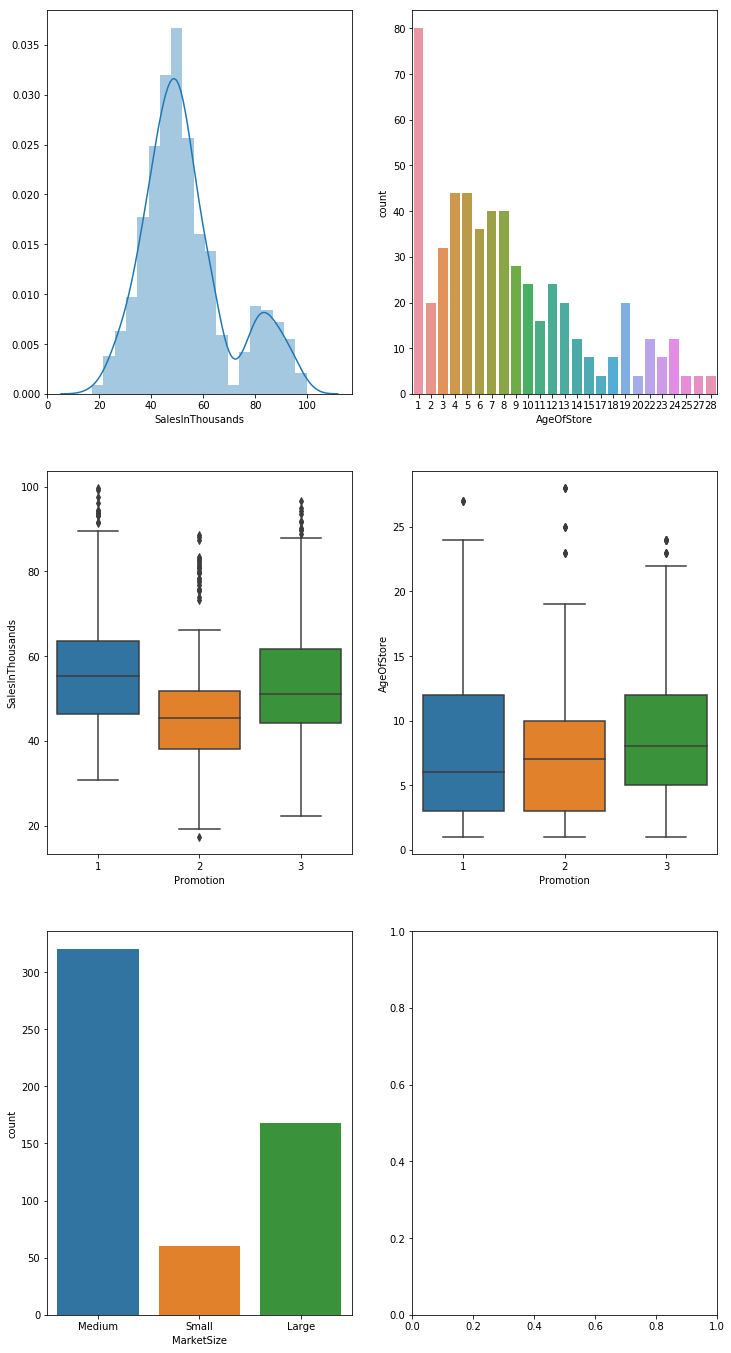

In [40]:
#Visualizing Data
figure, ax = plt.subplots(nrows = 3,ncols = 2, figsize=(12,24))

#See the distribution of the data
sns.distplot(df['SalesInThousands'],ax= ax[0,0])
sns.countplot(df['AgeOfStore'],ax=ax[0,1])
sns.boxplot(x=df["Promotion"], y=df["SalesInThousands"], ax=ax[1,0])
sns.boxplot(x=df['Promotion'], y=df['AgeOfStore'], ax=ax[1,1])
sns.countplot(df['MarketSize'], ax= ax[2,0])




We see that promotion 1 has the most average sales
followed by promotion 3 just like in our summary statistics table


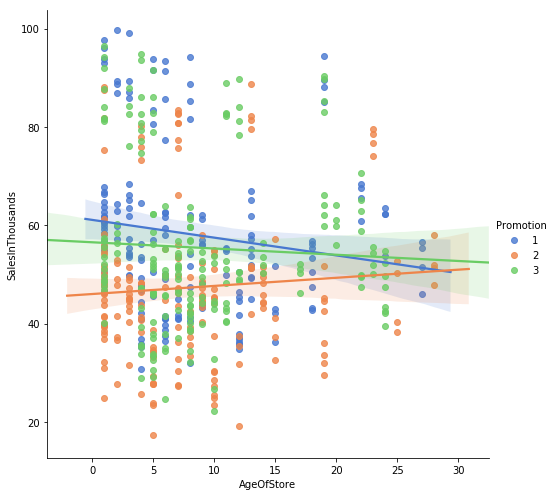

In [23]:
#Regression plot on age of store and sales in thousands color-coded by promotion
#This is an interesting chart, albeit not very actionable for us.
sns.lmplot(x="AgeOfStore", y="SalesInThousands", hue="Promotion", data=df, palette = 'muted', height = 7)
plt.show(sns)

In [8]:
#Before we model data we need to treat the promotion variable as a category or
#factor variable and not a numeric variable
df['Promotion'] = df['Promotion'].astype('category')

# Build anova model using OLS

In [12]:
#Build anova model
anova_lm = ols('SalesInThousands ~ Promotion', data=df).fit()

anova_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       SalesInThousands   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     21.95
Date:                Wed, 10 Feb 2021   Prob (F-statistic):           6.77e-10
Time:                        08:43:36   Log-Likelihood:                -2300.5
No. Observations:                 548   AIC:                             4607.
Df Residuals:                     545   BIC:                             4620.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         58.0990      1.231     47.186      0.000      55.680      60.518
Promotion[T.2]   -10.7696      1.704     -6.321      0.000     -14.116      -7.423
Promotion[T.3]    -2.7345      1.704     -1.605      0.109      -6.081       0.612
==============================================================================
Omnibus:                       52.072   Durbin-Watson:                   0.251
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.242
Skew:                           0.842   Prob(JB):                     6.81e-15
Kurtosis:                       3.137   Cond. No.                         3.83
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Notice the warning message and the text that says, “Covariance Type: nonrobust”. We will address this in a moment.

In [13]:
#Is the p-value (prob of F-statistic) significant?
6.77e-10 < 0.05

True

In [14]:
#Build 2nd anova model with robust covariance argument
anova_lm_02 = ols('SalesInThousands ~ Promotion', data=df).fit(cov_type = 'HC3')

anova_lm_02.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       SalesInThousands   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     23.14
Date:                Wed, 10 Feb 2021   Prob (F-statistic):           2.26e-10
Time:                        10:43:46   Log-Likelihood:                -2300.5
No. Observations:                 548   AIC:                             4607.
Df Residuals:                     545   BIC:                             4620.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         58.0990      1.266     45.895      0.000      55.618      60.580
Promotion[T.2]   -10.7696      1.680     -6.410      0.000     -14.063      -7.476
Promotion[T.3]    -2.7345      1.762     -1.552      0.121      -6.189       0.720
==============================================================================
Omnibus:                       52.072   Durbin-Watson:                   0.251
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.242
Skew:                           0.842   Prob(JB):                     6.81e-15
Kurtosis:                       3.137   Cond. No.                         3.83
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [15]:
#Is the p-value (prob of F-statistic) significant for our 2nd anova model?
2.26e-10 < 0.05

True

Our 2nd anova model reduced the coefficient errors slightly and is still significant.

Let's interpret the output of the 2nd linear model

The model is significant with the prob of F-statistic of 2.26e-10.
This tells us that there is a significant difference in the group means. 
The coefficients (coef), are the difference in mean between the promotion groups
and the respective group listed. The intercept is the mean for the promotion group 1

Looking at the p-values now (P>|t| in the table),
we can see the difference between group 1 and group 2 is significant, p = 0.000,
but the difference between the group 1 and group 3 is not, p = 0.121. 

Because group 1 is on the intercept we don't know where the differences
are between all pair groupings (Group 2 and Group 3)

# Post-hoc testing

Post-Hoc testing

Assuming your F value is significant, which it is, you can run the post hoc test.
https://www.statisticshowto.com/tukey-test-honest-significant-difference/

After you have run an ANOVA and found significant results,
then you can run Tukey’s HSD to find out which specific group means (compared with each other) are different. The test compares all possible pairs of means.

Assumptions for the test
-Observations are independent within and among groups.
-The groups for each mean in the test are normally distributed.
-There is equal within-group variance across the groups
associated with each mean in the test (homogeneity of variance).

In [13]:
# Set up the data for comparison
posthoc = MultiComparison(df['SalesInThousands'],
                            df['Promotion'])

# Print all pair-wise comparisons:
print(posthoc.tukeyhsd().summary())
#A results of ’reject = True’ means that a significant difference has been observed.


Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  1      2    -10.7696 -14.774 -6.7652  True 
  1      3    -2.7345  -6.7389  1.2698 False 
  2      3     8.0351   4.1207 11.9494  True 
---------------------------------------------


We can see that group 1 and 2 are significant.
Group 2 and 3 are signficant, but not groups 1 & 3. 
So promomtion 2 was the worst performing out of the 3 promotions.

# Conclusions

Summary: What should you tell the marketing &/or sales team?

Let's run again with just promotion 1 & 3 to
see if we can get a significant result.

It appeared in group 1 there were some stores that had slight differences than those stores
in the other groups e.g. some were slightly
younger it may not have made a difference but we should try to control for this.